<a href="https://colab.research.google.com/github/richaray/Image-Classification-with-CNN/blob/main/FlowerImageClassificationCNNipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
import pathlib
import tensorflow_hub as hub
import tf_keras
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.models import Sequential # type: ignore


In [6]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

228813984/228813984 [==============================] - 2s 0us/step


In [7]:
data_dir

'./datasets/flower_photos'

In [8]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


## Using **OpenCV** to read flower images from disk into numpy array
Images are also being resized and preprocessed

In [10]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [11]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [12]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [13]:
img.shape

(240, 320, 3)

In [14]:
cv2.resize(img,(180,180)).shape

(180, 180, 3)

In [15]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [16]:
X = np.array(X)
y = np.array(y)



**TRAIN TEST SPLIT**


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Preprocessing : Scale Images


In [18]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

## **Data** **Augmentation**

In [19]:
# Define image dimensions
img_height = 180
img_width = 180

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

**Original Image**

In [20]:
def show_image(img):
  plt.axis('off')
  plt.imshow(img)

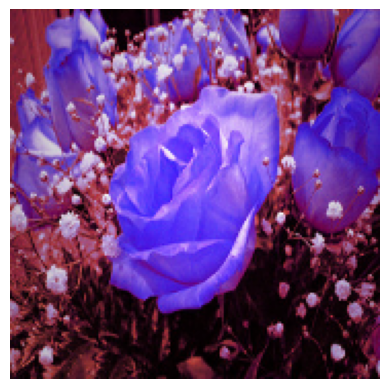

In [21]:
show_image(X[0])

**Newly generated training samples using data augmentation**

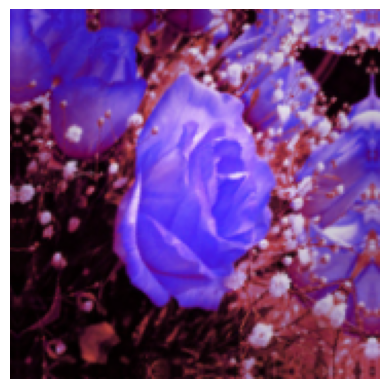

In [22]:
show_image(data_augmentation(X)[0].numpy().astype("uint8"))

In [24]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [25]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [26]:
X = np.array(X)
y = np.array(y)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [28]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255
print(X_train_scaled.shape)

(2752, 224, 224, 3)


## **Transfer Learning** using a pre-trained model from google's Tensorflow Hub

In [29]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [30]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [31]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

small_train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_train_scaled[:1000], y_train[:1000])
).batch(32)
model.fit(small_train_dataset, epochs=5)

# model.fit(X_train_scaled, y_train, batch_size=16, epochs=5)

Epoch 1/5
32/32 [==============================] - 8s 75ms/step - loss: 1.0838 - acc: 0.5860
Epoch 2/5
32/32 [==============================] - 2s 53ms/step - loss: 0.5590 - acc: 0.7980
Epoch 3/5
32/32 [==============================] - 2s 59ms/step - loss: 0.4210 - acc: 0.8610
Epoch 4/5
32/32 [==============================] - 2s 51ms/step - loss: 0.3385 - acc: 0.9040
Epoch 5/5
32/32 [==============================] - 2s 51ms/step - loss: 0.2818 - acc: 0.9280


## **Evaluation Metrics**

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [33]:
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

29/29 [==============================] - 2s 68ms/step


In [34]:
def eval_metrics(y_test, y_pred_classes, flowers_labels_dict):
  conf_matrix = confusion_matrix(y_test, y_pred_classes)
  print("Confusion Matrix:\n", conf_matrix)

  class_report = classification_report(y_test, y_pred_classes, target_names=flowers_labels_dict)
  print("\nClassification Report:\n", class_report)

  accuracy = accuracy_score(y_test, y_pred_classes)
  print("\nAccuracy:", accuracy)

In [35]:
eval_metrics(y_test, y_pred_classes, flowers_labels_dict)

Confusion Matrix:
 [[129   4   3   7  33]
 [  3 130   8   8   5]
 [  0  13 197   9   7]
 [  0   9   3 121  17]
 [ 11   4   2   7 188]]

Classification Report:
               precision    recall  f1-score   support

       roses       0.90      0.73      0.81       176
       daisy       0.81      0.84      0.83       154
   dandelion       0.92      0.87      0.90       226
  sunflowers       0.80      0.81      0.80       150
      tulips       0.75      0.89      0.81       212

    accuracy                           0.83       918
   macro avg       0.84      0.83      0.83       918
weighted avg       0.84      0.83      0.83       918


Accuracy: 0.8333333333333334
